### TransformerEncoder layers for transforming the ECG to the R-peaks encoding

In [2]:
import pickle
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from torch.utils.data import DataLoader
from models.datasets import ECGDataset
from models.models import SimpleTransformerModel
from customLib.vis import plot_ecg
from customLib.dataset import read_dataset
from customLib.config import fantasia_path, mitbih_path
from customLib.vis import plot_metrics
from customLib.print_model_parameters import print_model_parameters
from customLib.load_physionet_ecgs import load_physionet_ecgs
from customLib.metrics import print_metrics
from customLib.peak_detection import correct_prediction_according_to_aami

In [19]:
x_train, y_train, x_test, y_test, x_val, y_val = read_dataset(mitbih_path + "\\dataset\\raw\\downsampled", is_validation_set=True)

In [ ]:
x_train = np.expand_dims(x_train, 2)
y_train = np.expand_dims(y_train, 2)

x_test = np.expand_dims(x_test, 2)
y_test = np.expand_dims(y_test, 2)

x_val = np.expand_dims(x_val, 2)
y_val = np.expand_dims(y_val, 2)

plot_ecg(x_train[100].flatten(), y_train[100].flatten(), 100)
plot_ecg(x_test[-1].flatten(), y_test[-1].flatten(), 100)
plot_ecg(x_val[-1].flatten(), y_val[-1].flatten(), 100)

In [23]:
epochs=50
batch_size = 100
input_dim = 32
seq_length = x_train.shape[1]
num_layers = 2
num_heads = 4
dim_feedforward = 32
dropout = 0.2

model = SimpleTransformerModel(input_dim, seq_length, num_layers, num_heads, dim_feedforward, dropout, checkpoint_path="./checkpoints/TNET/raw_ecgs")
# model.load_state_dict(torch.load(".\\checkpoints\\TNET\\raw_ecgs\\\TNET_epoch_50_acc_98.96_f1_0.93.pt"))

Training will be performed with: cuda:0


<>:11: SyntaxWarning: invalid escape sequence '\T'
<>:11: SyntaxWarning: invalid escape sequence '\T'
C:\Users\patry\AppData\Local\Temp\ipykernel_13864\2682576774.py:11: SyntaxWarning: invalid escape sequence '\T'
  model.load_state_dict(torch.load(".\\checkpoints\\TNET\\raw_ecgs\\\TNET_epoch_50_acc_98.96_f1_0.93.pt"))
C:\Users\patry\AppData\Local\Temp\ipykernel_13864\2682576774.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by

<All keys matched successfully>

In [5]:
print_model_parameters(model)

Layer embedding_layer: 4736 parameters
Layer embedding_layer.0: 64 parameters
Layer embedding_layer.2: 1568 parameters
Layer embedding_layer.4: 3104 parameters
Layer encoder_layer: 6464 parameters
Layer encoder_layer.self_attn: 4224 parameters
Layer encoder_layer.self_attn.out_proj: 1056 parameters
Layer encoder_layer.linear1: 1056 parameters
Layer encoder_layer.linear2: 1056 parameters
Layer encoder_layer.norm1: 64 parameters
Layer encoder_layer.norm2: 64 parameters
Layer transformer_encoder: 12928 parameters
Layer transformer_encoder.layers: 12928 parameters
Layer transformer_encoder.layers.0: 6464 parameters
Layer transformer_encoder.layers.0.self_attn: 4224 parameters
Layer transformer_encoder.layers.0.self_attn.out_proj: 1056 parameters
Layer transformer_encoder.layers.0.linear1: 1056 parameters
Layer transformer_encoder.layers.0.linear2: 1056 parameters
Layer transformer_encoder.layers.0.norm1: 64 parameters
Layer transformer_encoder.layers.0.norm2: 64 parameters
Layer transforme

In [ ]:
model.train_model(x_train=x_train, y_train=y_train, epochs=epochs, batch_size=batch_size, x_val=x_val, y_val=y_val)

In [24]:
model.test_model(x_test, y_test)

  0%|          | 0/396 [00:00<?, ?it/s]e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████| 396/396 [00:22<00:00, 17.82it/s]



Test Loss: 0.0804
test Weighted Accuracy: 0.98960
test F1 Score: 0.93357
test TPR: 0.98075
test FPR: 0.00154
test TNR: 0.99846
test FNR: 0.01925



In [29]:
import pickle
with open("./metrics/raw/TNET.pkl", "wb") as f:
  pickle.dump(model.get_metrics(), f)

In [30]:
with open("./metrics/raw/TNET.pkl", "rb") as f:
  metrics = pickle.load(f)

In [ ]:
plot_metrics(metrics)

In [ ]:
print_metrics(metrics, "all", 49)

## Test with Fantasia and own dataset

In [3]:
batch_size = 100
input_dim = 32
seq_length = 1000
num_layers = 2
num_heads = 4
dim_feedforward = 32
dropout = 0.2

transformer = SimpleTransformerModel(input_dim, seq_length, num_layers, num_heads, dim_feedforward, dropout)
transformer.load_state_dict(torch.load(".\\checkpoints\\TNET\\TNET_epoch_50_acc_98.80_f1_0.93.pt"))

raw_transformer = SimpleTransformerModel(input_dim, seq_length, num_layers, num_heads, dim_feedforward, dropout) # trained on raw ECGS but still downsampled due to o(n^2) complexity
raw_transformer.load_state_dict(torch.load(".\\checkpoints\\TNET\\raw_ecgs\\TNET_epoch_50_acc_98.96_f1_0.93.pt"))


Training will be performed with: cuda:0


e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Training will be performed with: cuda:0


C:\Users\patry\AppData\Local\Temp\ipykernel_24496\3463870443.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer.load_state_dict(torch.load(".\\checkpoints\\TNE

<All keys matched successfully>

In [4]:

x = np.load(fantasia_path + "\\preprocessed\\downsampled\\x.npy")
y = np.load(fantasia_path + "\\preprocessed\\downsampled\\y.npy")

x_raw = np.load(fantasia_path + "\\preprocessed\\raw\\downsampled\\x.npy")
y_raw = np.load(fantasia_path + "\\preprocessed\\raw\\downsampled\\y.npy")


x = np.expand_dims(x, 2)
y = np.expand_dims(y, 2)

x_raw =  np.expand_dims(x_raw, 2)
y_raw = np.expand_dims(y_raw, 2)

In [3]:
x_aidmed = np.load(".\\aidmed_ecgs\\preprocessed\\downsampled\\x.npy")
y_aidmed = np.load(".\\aidmed_ecgs\\preprocessed\\downsampled\\y.npy")

x_aidmed_raw = np.load(".\\aidmed_ecgs\\raw\\downsampled\\x.npy")
y_aidmed_raw = np.load(".\\aidmed_ecgs\\raw\\downsampled\\y.npy")

x_aidmed = np.expand_dims(x_aidmed, 2)
y_aidmed = np.expand_dims(y_aidmed, 2)

x_aidmed_raw = np.expand_dims(x_aidmed_raw, 2)
y_aidmed_raw = np.expand_dims(y_aidmed_raw, 2)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def test_model(model, x_test, y_test, plot=False, plot_raw_pred=False):
    test_dataset = ECGDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    running_loss = 0.0
    num_r_peaks = 0.0
    num_correct = 0.0

    all_outputs = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for i, (x_test, y_test) in tqdm(enumerate(test_loader), total=len(test_loader)):
            x, y = x_test.to(device), y_test.to(device)
            outputs = model(x)

            loss = model.criterion(outputs, y)
            running_loss += loss.item()

            outputs = outputs.cpu().detach().numpy()
            y = y.cpu().detach().numpy()

            num_r_peaks += np.where(y == 1)[0].shape[0]
            num_correct += np.where((outputs > 0.5) & (y == 1))[0].shape[0]

            all_outputs.extend(outputs.flatten())
            all_labels.extend(y.flatten())

            ecg = x[0].cpu().detach().numpy().flatten()
            gt = y[0].flatten()
            raw_pred = outputs[0].flatten()

            pred = (raw_pred > 0.5).astype(np.int32)

            corrected_r_peaks = correct_prediction_according_to_aami(y_true=gt, y_pred=pred, sampling_rate=ecg.shape[0] / 10)

            correct_r_peaks = np.where((corrected_r_peaks == 1) & (gt == 1))[0]
            false_positives = np.where((corrected_r_peaks == 1) & (gt == 0))[0]
            false_negatives = np.where((corrected_r_peaks == 0) & (gt == 1))[0]

            if (len(false_positives) > 0 or len(false_negatives) > 0) and plot == True:
                gt_line = Line2D([0], [0], color='orange', label='GT', linestyle='-')
                prediction_line = Line2D([0], [0], color='mediumblue', label='Predykcja', linestyle='-')
                raw_prediction_line = Line2D([0], [0], color='deeppink', label='Surowa\npredykcja', linestyle='-')
                correct_line = Line2D([0], [0], color='green', label='TP', linestyle='-')
                error_fp = Line2D([0], [0], color='crimson', label='FP', linestyle='-')
                error_fn = Line2D([0], [0], color='darkviolet', label='FN', linestyle='-')

                fig, axs = plt.subplots(nrows=3, sharex=True)
                ax = axs[0]
                ax.plot(ecg, 'dodgerblue')
                ax.legend(["ECG"], loc="lower right", bbox_to_anchor=(1.16,0.36))
                ax.grid()
                ax.set_ylabel("EKG", fontweight="semibold", fontsize=12)

                ax = axs[1]
                ax.plot(pred, 'mediumblue')
                ax.plot(gt, 'orange')

                handles = [gt_line, prediction_line]
                if plot_raw_pred:
                    ax.plot(raw_pred,'deeppink')
                    handles.append(raw_prediction_line)
                ax.grid()
                ax.legend(handles=handles, loc="lower right", bbox_to_anchor=(1.22,0.28))

                #ax = axs[2]
                #ax.plot(pred_raw)
                #ax.legend(["Raw prediction"])
                #ax.grid()

                ax = axs[2]
                ax.plot(gt, 'g-')
                ax.grid()
                ax.legend(handles=[correct_line, error_fp, error_fn], loc="lower right", bbox_to_anchor=(1.14,0.2))
                ax.set_ylabel("Prawdopodobieństwo", fontweight="semibold", fontsize=12, y=1.2, labelpad=16)

                for correct in correct_r_peaks:
                    ax.vlines(correct, 0, 1, color='g', linestyle='-')
                for fp in false_positives:
                    ax.vlines(fp, 0, 1, color='crimson', linestyle='-', linewidth=2)
                for fn in false_negatives:
                    ax.vlines(fn, 0, 1, color='darkviolet', linestyle='-', linewidth=2)

                fig.supxlabel('Numer próbki', fontweight="semibold")


                fig.set_size_inches(8,6)
                plt.show()
                
            if i == 200:
                break
            
    # all_outputs = np.array(all_outputs)
    # all_labels = np.array(all_labels)
    # y_pred_binary = (all_outputs > 0.5).astype(int)
    # test_loss = running_loss / len(test_loader)
    # print(f"\nTest Loss: {test_loss:.4f}")
    # model.calculate_metrics(test_loss, all_labels, y_pred_binary, "test")

In [ ]:
test_model(transformer, x, y, True)

 48%|████▊     | 48/99 [00:00<00:00, 134.57it/s]

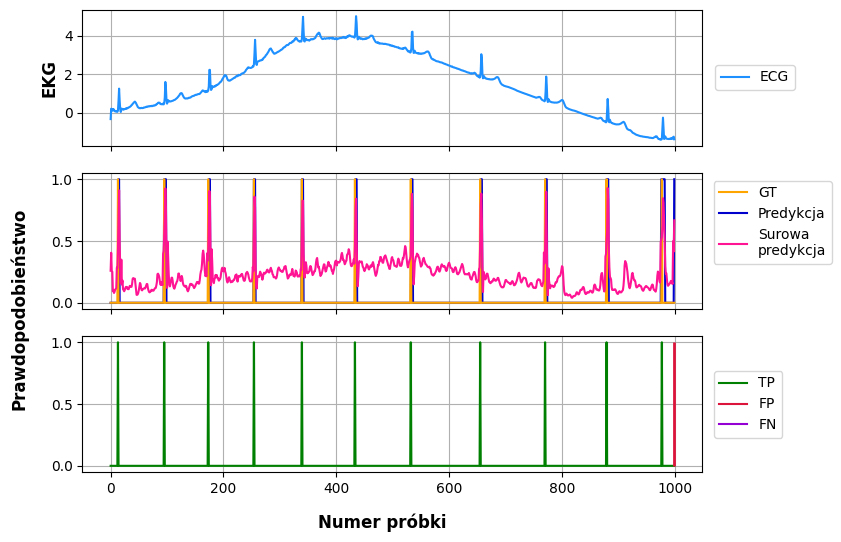

 63%|██████▎   | 62/99 [00:00<00:00, 63.91it/s] 

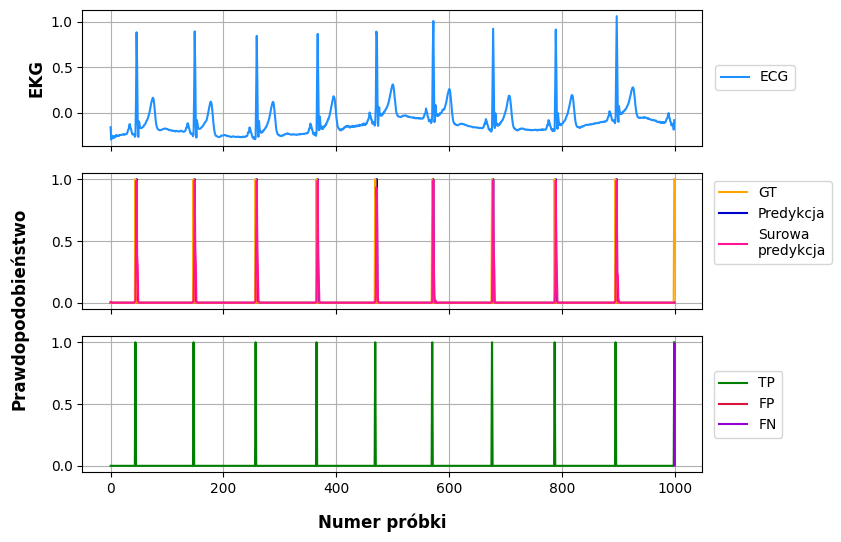

 78%|███████▊  | 77/99 [00:01<00:00, 49.00it/s]

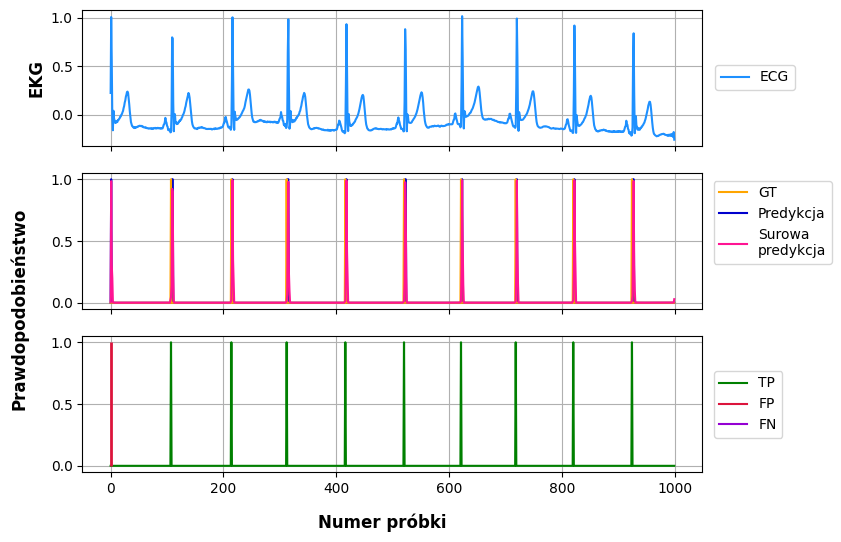

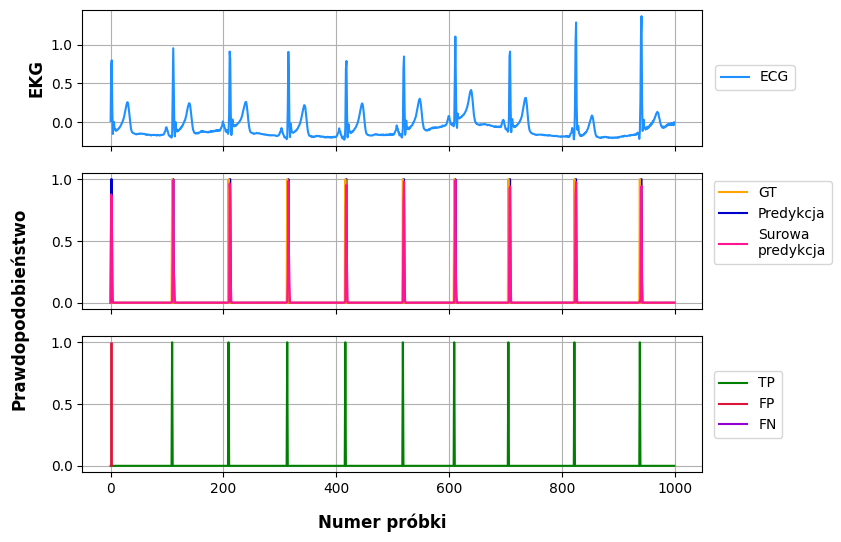

 97%|█████████▋| 96/99 [00:02<00:00, 34.87it/s]

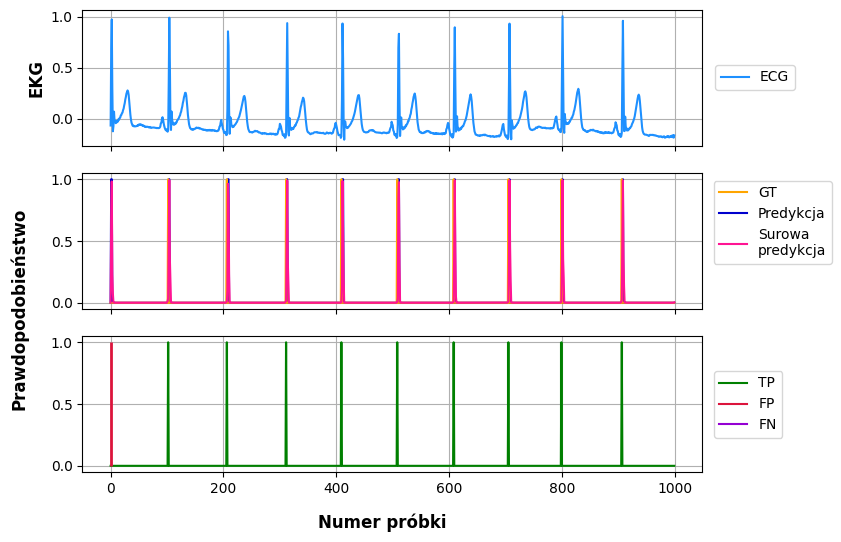

100%|██████████| 99/99 [00:02<00:00, 39.05it/s]


In [7]:
test_model(raw_transformer, x_test=x_raw[-100:-1,:,:], y_test=y_raw[-100:-1,:,:], plot=True, plot_raw_pred=True)

In [ ]:
test_model(transformer, x_aidmed, y_aidmed, plot=True, plot_raw_pred=True)

  0%|          | 0/462 [00:00<?, ?it/s]

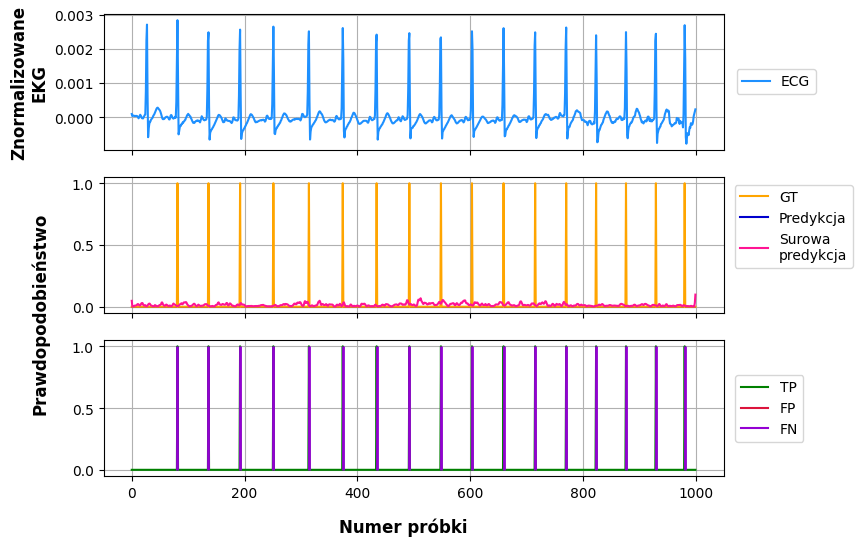

  0%|          | 1/462 [00:00<02:55,  2.63it/s]

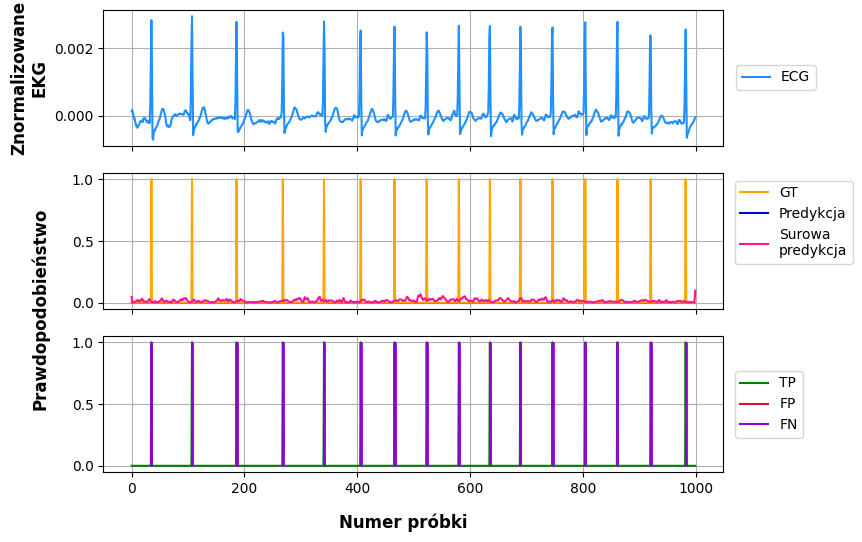

  0%|          | 2/462 [00:00<02:57,  2.59it/s]

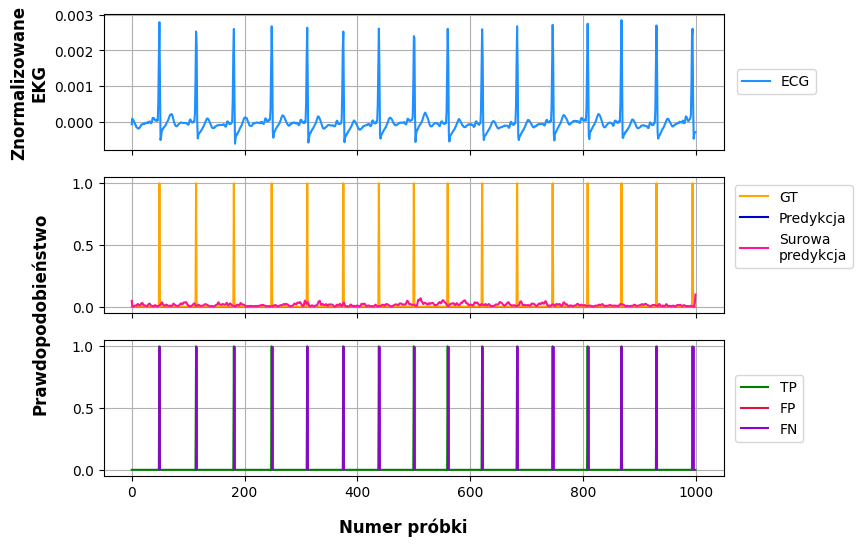

  1%|          | 3/462 [00:01<03:02,  2.51it/s]

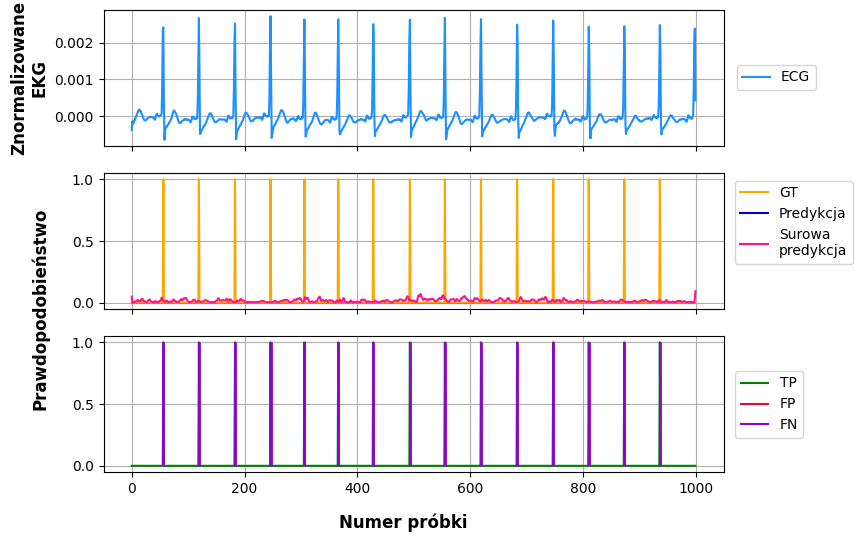

  1%|          | 4/462 [00:01<03:02,  2.51it/s]

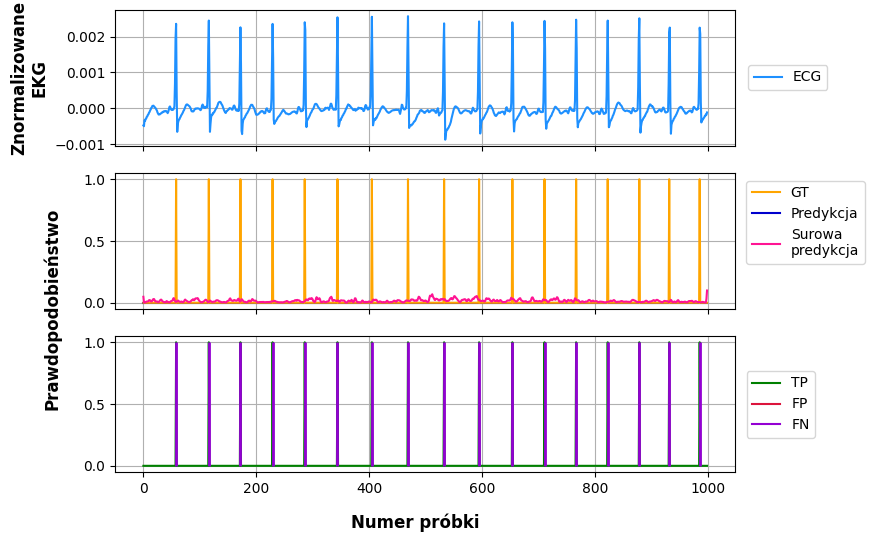

  1%|          | 5/462 [00:01<03:02,  2.50it/s]

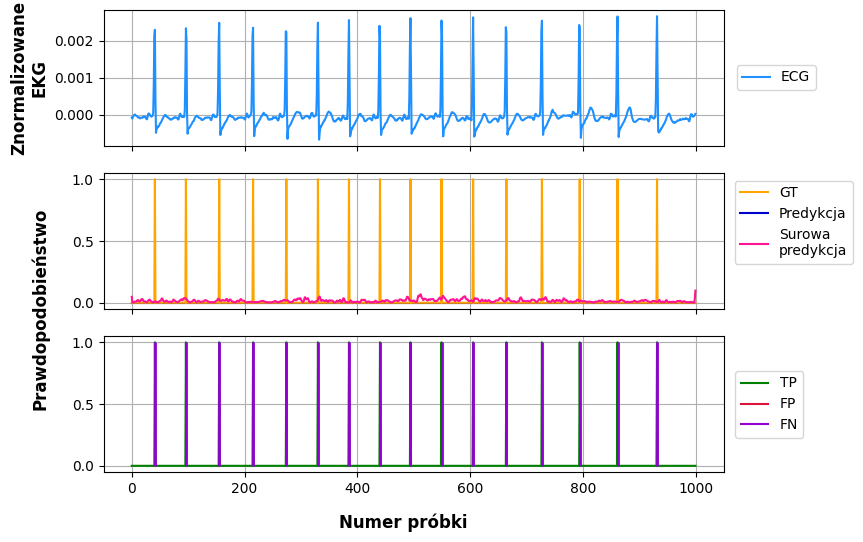

  1%|▏         | 6/462 [00:02<03:07,  2.44it/s]

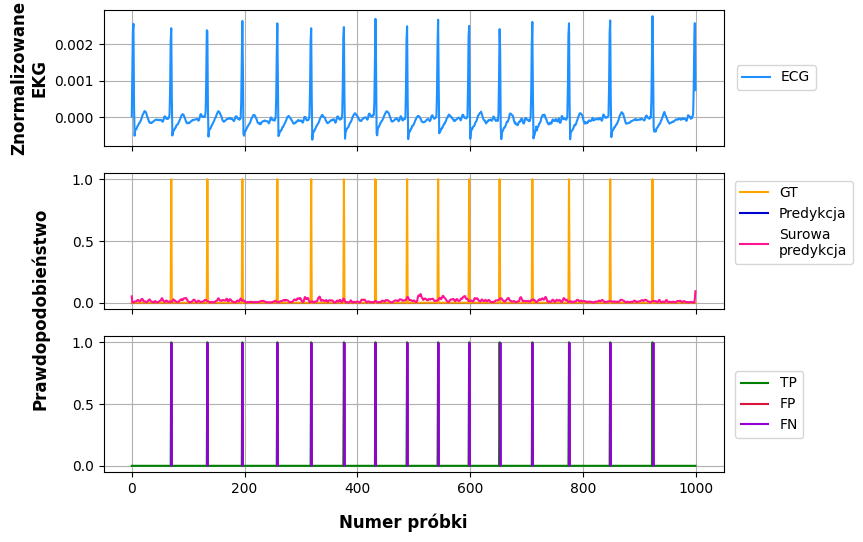

  2%|▏         | 7/462 [00:02<03:09,  2.40it/s]

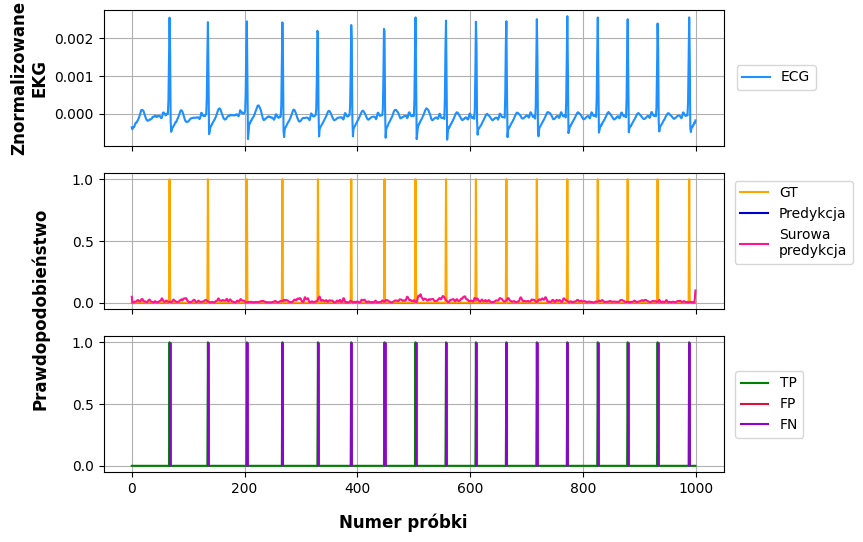

  2%|▏         | 8/462 [00:03<03:19,  2.28it/s]

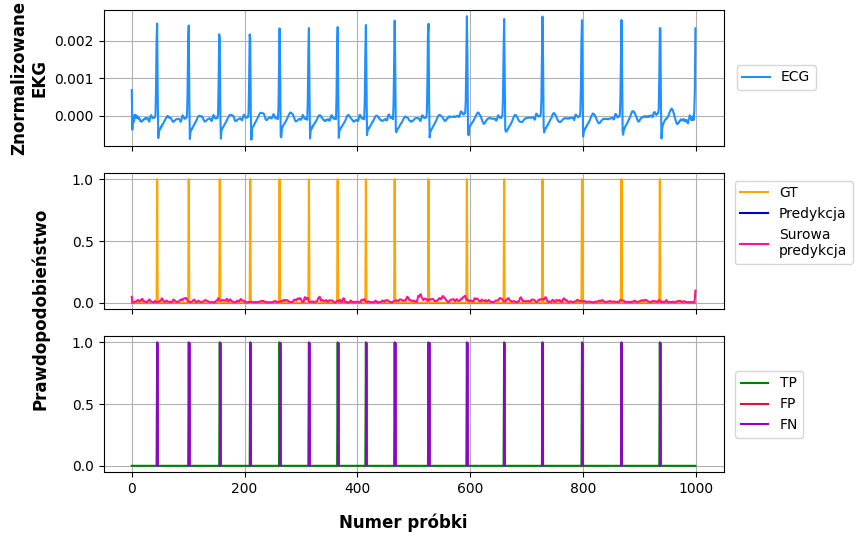

  2%|▏         | 9/462 [00:03<03:07,  2.41it/s]

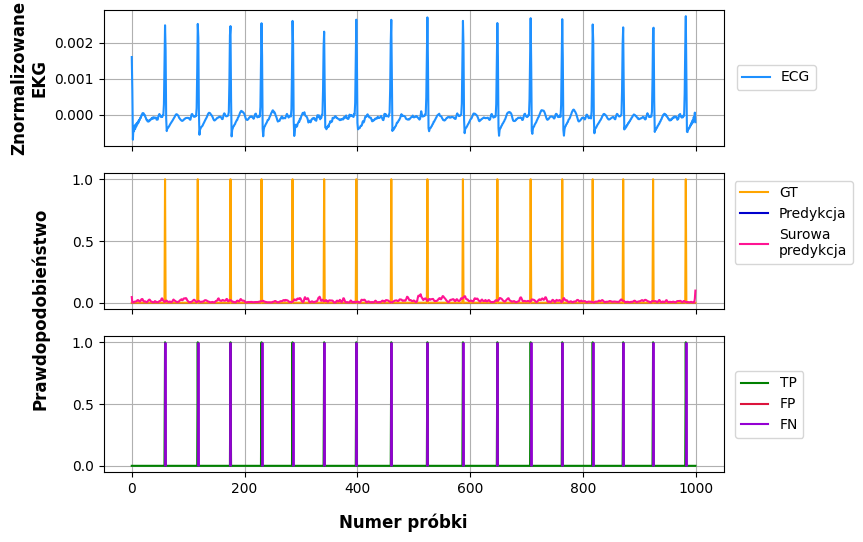

  2%|▏         | 10/462 [00:04<04:00,  1.88it/s]

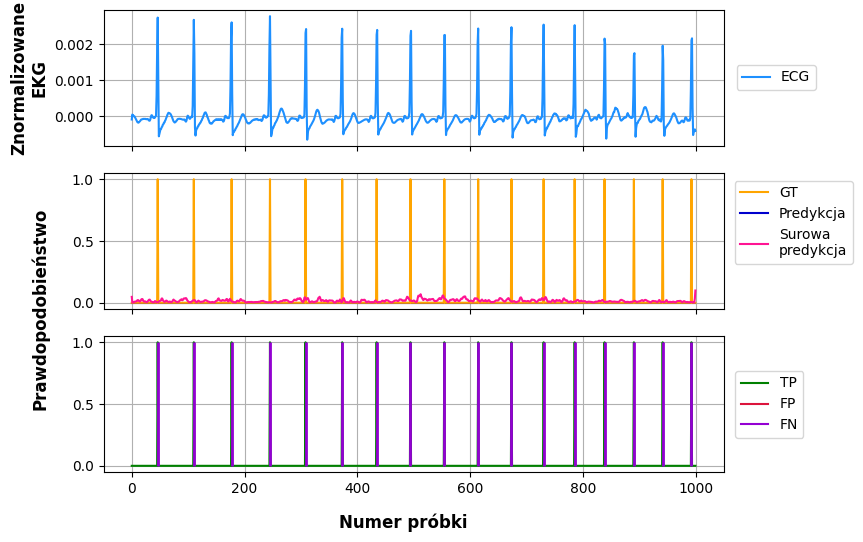

  2%|▏         | 11/462 [00:04<03:51,  1.94it/s]

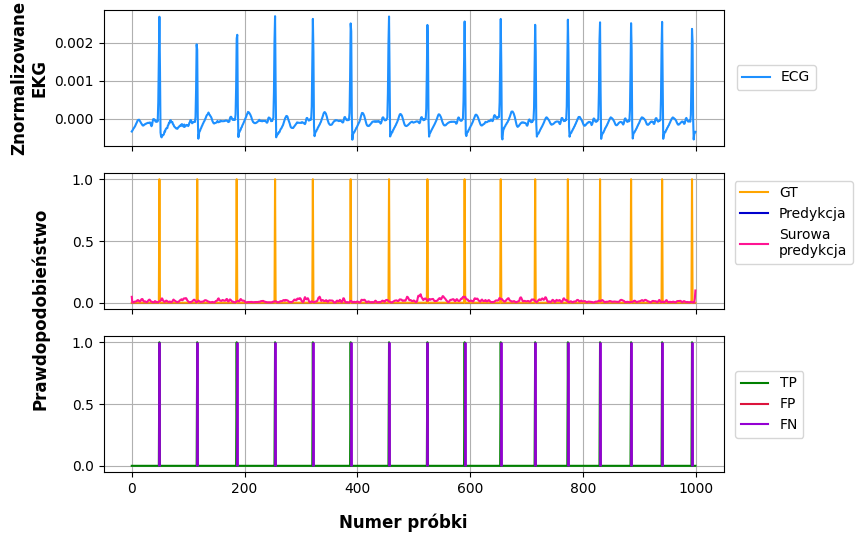

  3%|▎         | 12/462 [00:05<03:28,  2.16it/s]

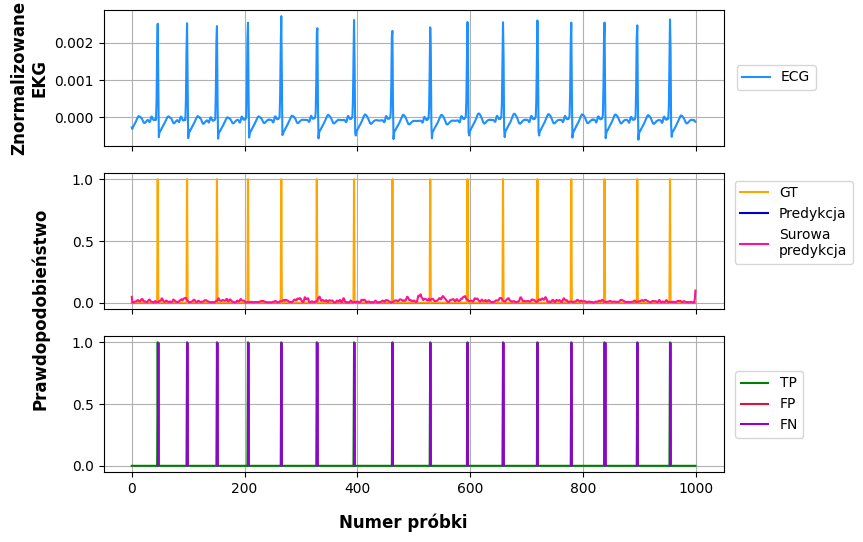

  3%|▎         | 13/462 [00:05<03:16,  2.29it/s]

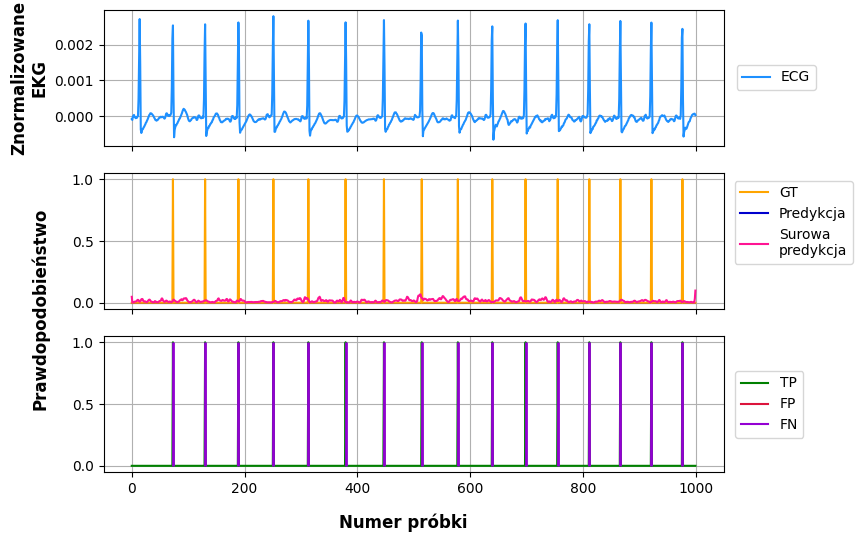

  3%|▎         | 14/462 [00:06<03:09,  2.36it/s]

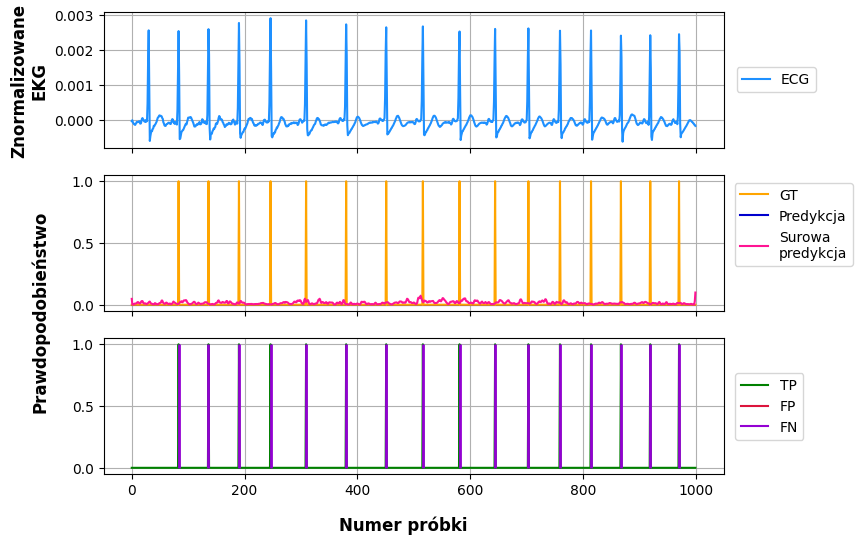

  3%|▎         | 15/462 [00:06<03:04,  2.43it/s]

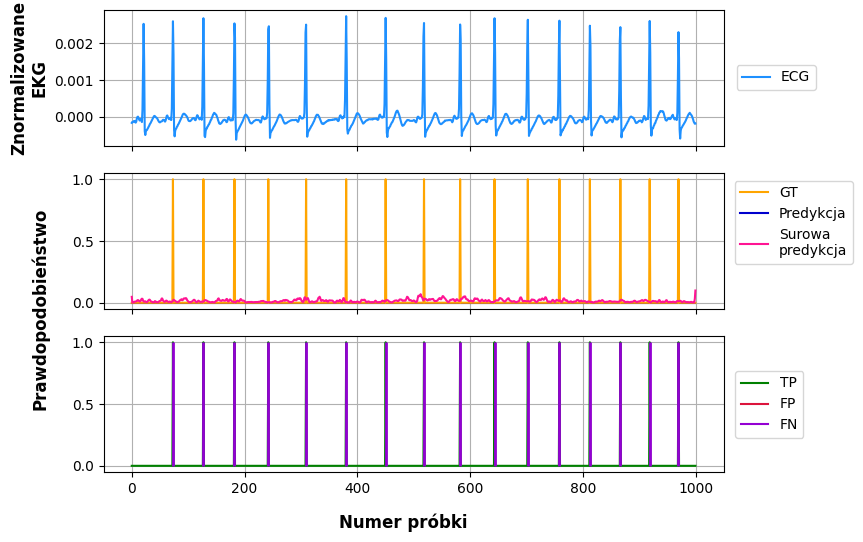

  3%|▎         | 16/462 [00:06<02:57,  2.51it/s]

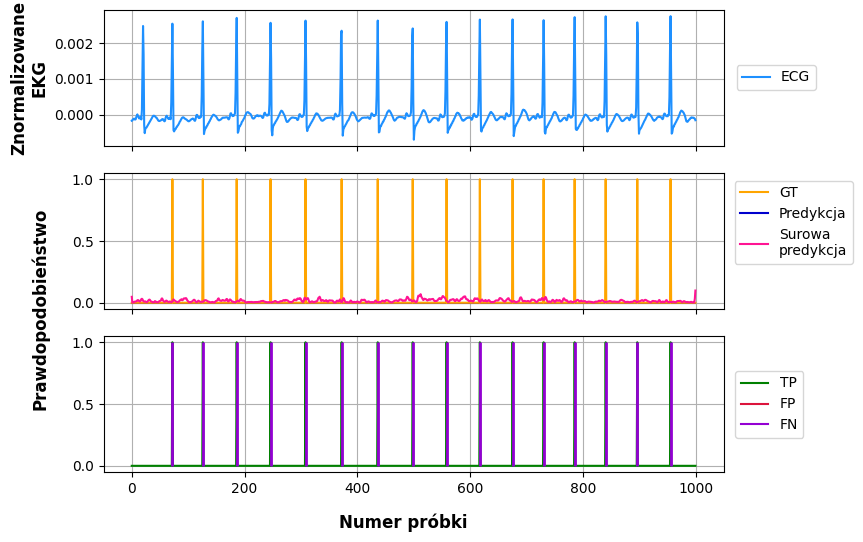

  4%|▎         | 17/462 [00:07<02:57,  2.51it/s]

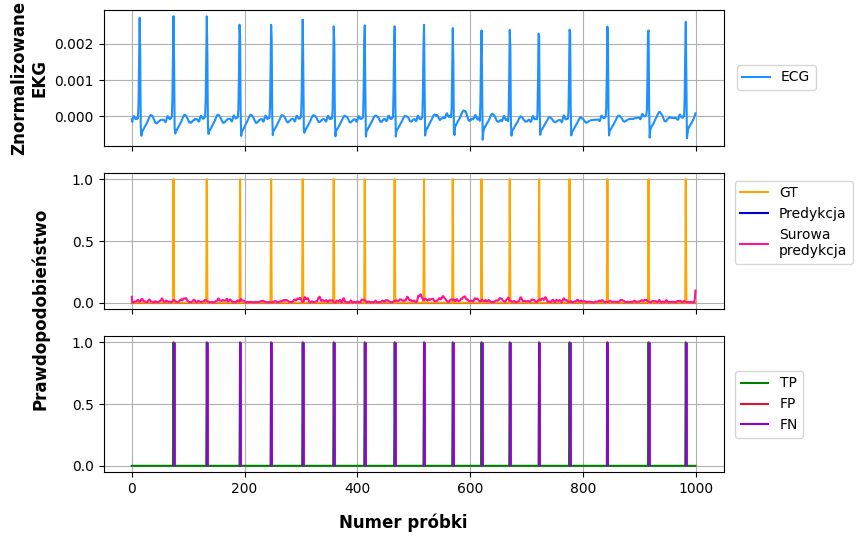

  4%|▍         | 18/462 [00:07<02:52,  2.57it/s]

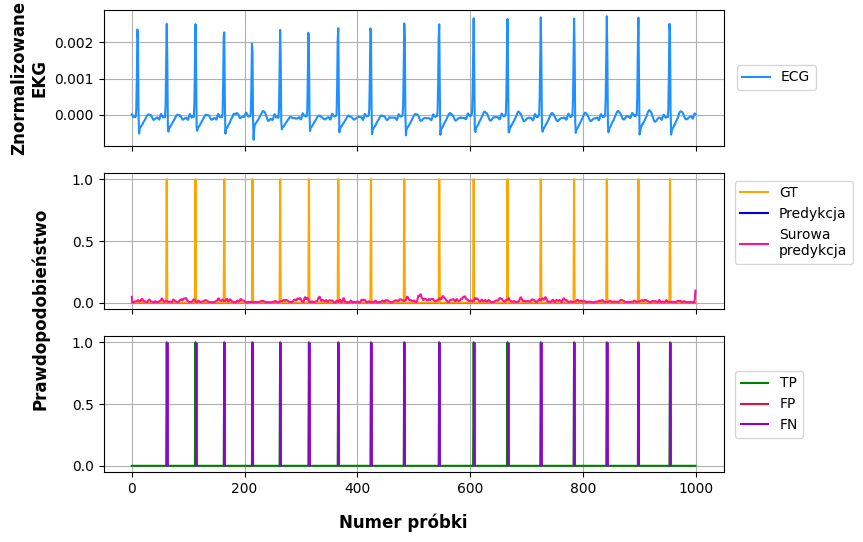

  4%|▍         | 19/462 [00:07<02:51,  2.58it/s]

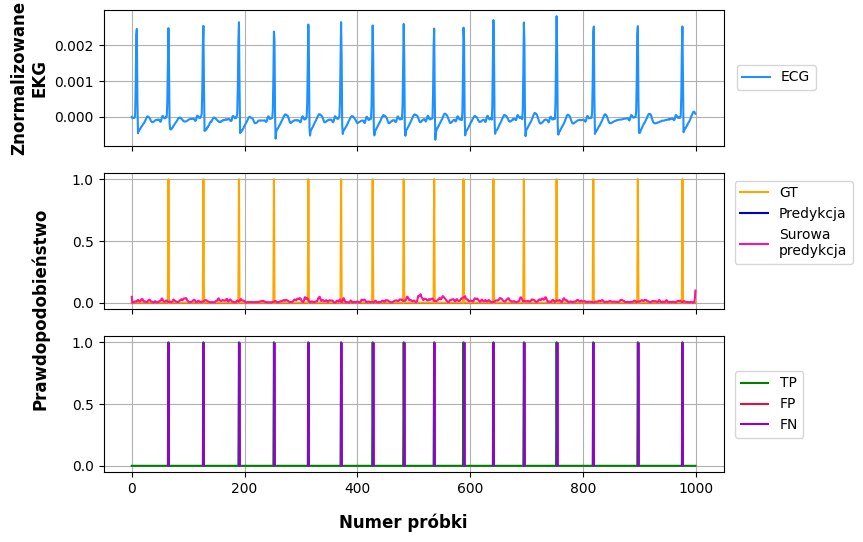

  4%|▍         | 20/462 [00:08<02:57,  2.49it/s]

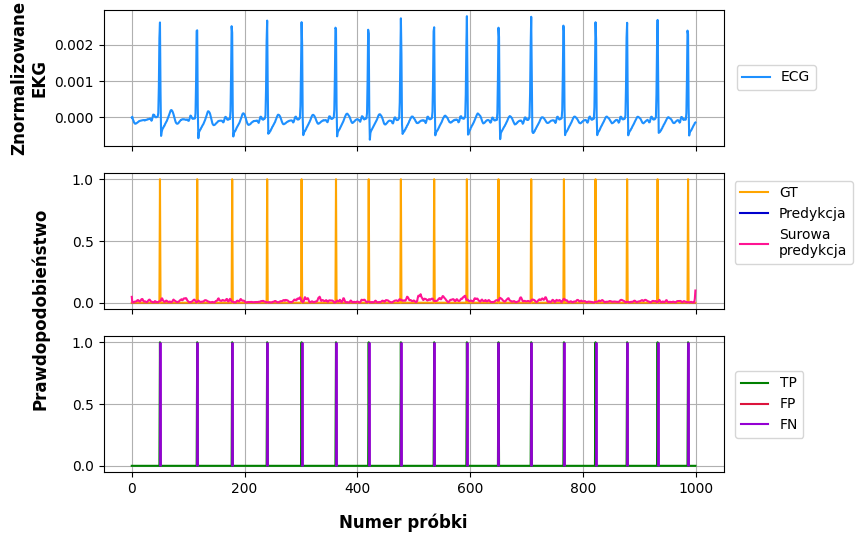

  5%|▍         | 21/462 [00:08<02:54,  2.52it/s]

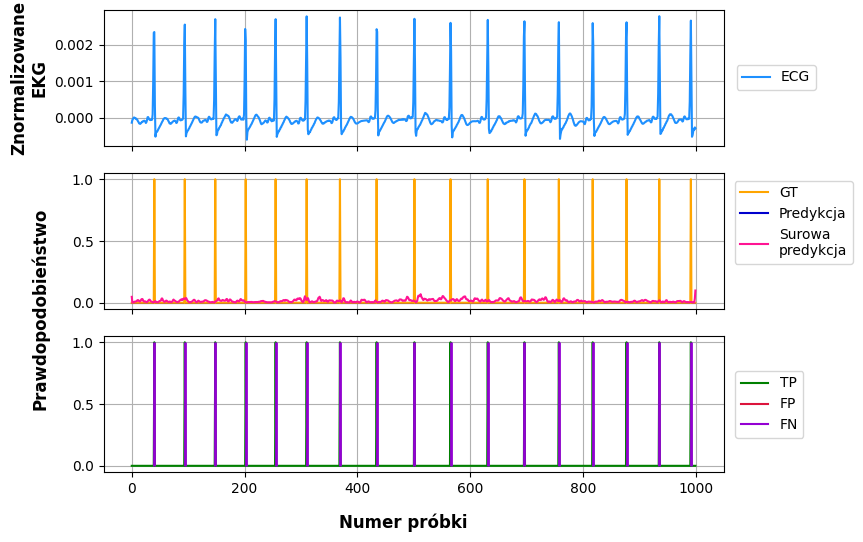

  5%|▍         | 22/462 [00:09<03:07,  2.35it/s]


KeyboardInterrupt: 

In [14]:
test_model(raw_transformer, x_aidmed_raw, y_aidmed_raw, plot=True, plot_raw_pred=True)